# Visualizing the distribution of episode trajectories

Note: video/image manipulation requires OpenCV, which isn't included in the conda environment setup for the rest of this project (out of fear of breaking other dependencies). To run this notebook, I suggest using a separate conda environment that has OpenCV installed (since we're just processing videos/images, the new conda environment doesn't need to have all the packages that `rl_vcf` has).

This can be done by following this guide: https://saturncloud.io/blog/installing-opencv-with-conda-a-guide-for-data-scientists/ (but use Python 3.10 instead).

Remember to also install the `ipykernel` and `matplotlib` packages for the new environment! `conda install ipykernel matplotlib`

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections.abc import Container
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [29]:
def extract_frames(
    datetime: str,
    ep_idxs: Container[int],
    backsub: cv2.BackgroundSubtractor | None = None,
    algo: str = "KNN",
    learning_rate: float = 0.01,
    crop_lims: tuple | None = None,
) -> tuple[list, cv2.BackgroundSubtractor]:
    """
    Extract frames from each episode video.
    """
    frames = []
    if backsub is None:
        if algo == "MOG2":
            backsub = cv2.createBackgroundSubtractorMOG2()
        elif algo == "KNN":
            backsub = cv2.createBackgroundSubtractorKNN()
        else:
            raise ValueError(
                "Invalid background subtraction algorithm; must be 'MOG2' or 'KNN'."
            )

    for ep_idx in ep_idxs:
        ep_frames = []
        cam = cv2.VideoCapture(
            "../../src/rl_vcf/outputs/"
            + datetime
            + "/videos/rl-video-episode-{ep_idx}.mp4".format(ep_idx=ep_idx)
        )
        while True:
            ret, frame = cam.read()
            if not ret:
                break
            if crop_lims is not None:
                frame = frame[crop_lims[0] : crop_lims[1], crop_lims[2] : crop_lims[3]]
            fgmask = backsub.apply(frame, learningRate=learning_rate)
            ep_frames.append(frame)

        # For some reason, each video for ep_idx > 0 has 1 extra frame at the start from the end of the previous episode
        if ep_idx > 0:
            ep_frames = ep_frames[1:]

        frames.append(ep_frames)

    cam.release()

    return frames, backsub


def plot_trajectories(
    frames: list,
    alpha: float,
    backsub: cv2.BackgroundSubtractor,
    update_rate: float = 1.0,
    keypoint_size_cutoff: int = 40,
    blur_size: tuple[int, int] = (3, 3),
    blob_detector: cv2.SimpleBlobDetector | None = None,
    color: str = "b",
) -> tuple[Figure, Axes]:

    trajectories = []
    positions = []
    for ep_frames in frames:
        trajectory = backsub.getBackgroundImage()
        ep_positions = []
        for idx in range(len(ep_frames)):
            fgmask = backsub.apply(ep_frames[idx])
            trajectory[fgmask > 0] = (
                trajectory[fgmask > 0] * (1 - update_rate)
                + ep_frames[idx][fgmask > 0] * update_rate
            )
            gray = cv2.cvtColor(ep_frames[idx], cv2.COLOR_BGR2GRAY)
            gray_blurred = cv2.blur(gray, blur_size)
            keypoints = blob_detector.detect(gray_blurred)

            for kp in keypoints:
                if kp.size <= keypoint_size_cutoff:
                    x, y = kp.pt
                    x, y = int(x), int(y)
                    ep_positions.append((x, y))
        trajectories.append(trajectory)
        positions.append(ep_positions)

    trajectory_distribution = np.mean(trajectories, axis=0)

    fig, ax = plt.subplots()

    ax.imshow(cv2.cvtColor(trajectory_distribution.astype("uint8"), cv2.COLOR_BGR2RGB))

    for ep_positions in positions:
        # Extract x and y coordinates from ep_positions
        x_coords = [pos[0] for pos in ep_positions]
        y_coords = [pos[1] for pos in ep_positions]

        ax.plot(
            x_coords,
            y_coords,
            linestyle="-",
            linewidth="1.5",
            marker="o",
            markersize="1.5",
            color=color,
            alpha=0.5,
        )
    ax.set_title(r"$\alpha = {alpha}$".format(alpha=alpha))
    ax.axis("off")
    return fig, ax

In [30]:
# Episode indices
ep_idxs = np.arange(0, 1000, 100)

# Video cropping
crop_lims = (0, 200, 0, 200)

# Background subtraction params
# algo = "MOG2"
algo = "KNN"
backsub = None
learning_rate = 0.01

In [31]:
# Extract frames
alpha_1_frames, backsub = extract_frames(
    datetime="2025-01-10/13-03-47",
    ep_idxs=ep_idxs,
    backsub=backsub,
    algo=algo,
    learning_rate=learning_rate,
    crop_lims=crop_lims,
)
alpha_1_1_frames, backsub = extract_frames(
    datetime="2025-01-10/13-17-17",
    ep_idxs=ep_idxs,
    backsub=backsub,
    algo=algo,
    learning_rate=learning_rate,
    crop_lims=crop_lims,
)
alpha_5_frames, backsub = extract_frames(
    datetime="2025-01-10/13-31-02",
    ep_idxs=ep_idxs,
    backsub=backsub,
    algo=algo,
    learning_rate=learning_rate,
    crop_lims=crop_lims,
)
alpha_10_frames, backsub = extract_frames(
    datetime="2025-01-10/13-44-38",
    ep_idxs=ep_idxs,
    backsub=backsub,
    algo=algo,
    learning_rate=learning_rate,
    crop_lims=crop_lims,
)
alpha_100_frames, backsub = extract_frames(
    datetime="2025-01-10/13-58-14",
    ep_idxs=ep_idxs,
    backsub=backsub,
    algo=algo,
    learning_rate=learning_rate,
    crop_lims=crop_lims,
)

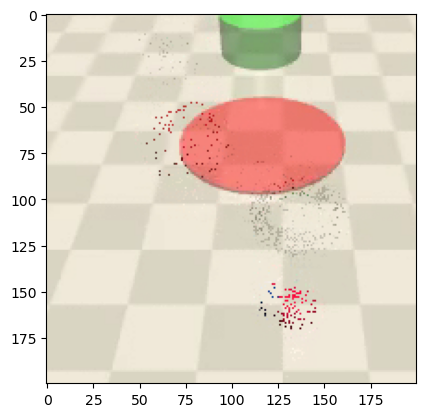

In [32]:
# Check background subtraction is working
plt.imshow(
    cv2.cvtColor(backsub.getBackgroundImage().astype("uint8"), cv2.COLOR_BGR2RGB)
)
plt.show()

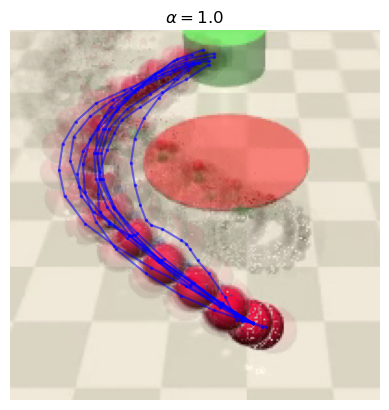

In [33]:
# Blob detection params
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 100
params.filterByCircularity = True
params.filterByConvexity = False
params.filterByInertia = False

# Create blob detector
blob_detector = cv2.SimpleBlobDetector_create(params)

# Plotting params
update_rate = 1.0
keypoint_size_cutoff = 40
blur_size = (3, 3)

fig, ax = plot_trajectories(
    frames=alpha_1_frames,
    backsub=backsub,
    alpha=1.0,
    update_rate=update_rate,
    keypoint_size_cutoff=keypoint_size_cutoff,
    blur_size=blur_size,
    blob_detector=blob_detector,
    color="b",
)

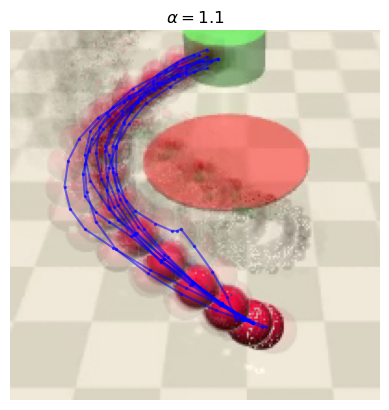

In [34]:
fix, ax = plot_trajectories(
    frames=alpha_1_1_frames,
    alpha=1.1,
    backsub=backsub,
    update_rate=update_rate,
    keypoint_size_cutoff=keypoint_size_cutoff,
    blur_size=blur_size,
    blob_detector=blob_detector,
    color="b",
)

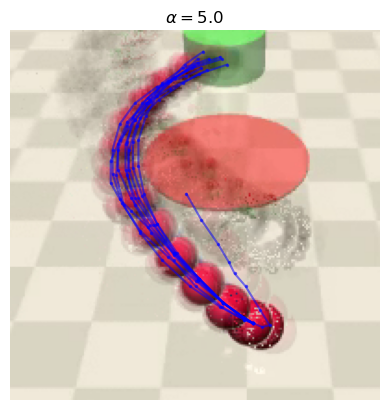

In [35]:
fig, ax = plot_trajectories(
    frames=alpha_5_frames,
    alpha=5.0,
    backsub=backsub,
    update_rate=update_rate,
    keypoint_size_cutoff=keypoint_size_cutoff,
    blur_size=blur_size,
    blob_detector=blob_detector,
    color="b",
)

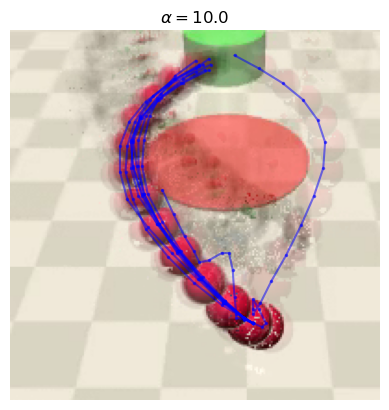

In [36]:
fig, ax = plot_trajectories(
    frames=alpha_10_frames,
    alpha=10.0,
    backsub=backsub,
    update_rate=update_rate,
    keypoint_size_cutoff=keypoint_size_cutoff,
    blur_size=blur_size,
    blob_detector=blob_detector,
    color="b",
)

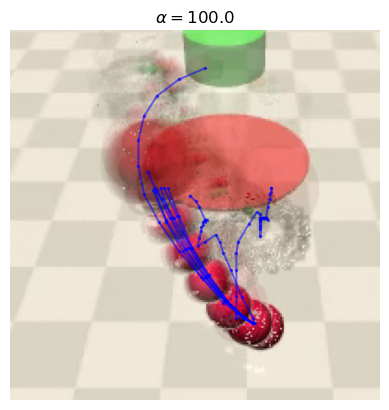

In [37]:
fig, ax = plot_trajectories(
    frames=alpha_100_frames,
    alpha=100.0,
    backsub=backsub,
    update_rate=update_rate,
    keypoint_size_cutoff=keypoint_size_cutoff,
    blur_size=blur_size,
    blob_detector=blob_detector,
    color="b",
)